In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf

import numba
from scipy.optimize import minimize
from scipy import stats

import pulp

import statsmodels.api as sm
import patsy

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from IPython.display import set_matplotlib_formats

# set_matplotlib_formats('svg')
mpl.rcParams['figure.figsize'] = [16, 12]

/home/chiao/miniconda3/lib/python3.10/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
# https://wholesale.banking.societegenerale.com/en/prime-services-indices/
sg_cta = pd.read_csv("sg_indices.csv").rename(columns={"trade_date": "date"})
sg_cta["date"] = pd.to_datetime(sg_cta["date"])
sg_cta = sg_cta.set_index("date")
cta_ret = sg_cta["SG CTA Index"].transform(lambda xs: xs / xs.shift() - 1)

In [4]:
dbmf_nav = (
    pd.read_excel("DBMF-Table.xlsx")
    .rename(columns=lambda xs: xs.lower())
)

display(dbmf_nav[dbmf_nav.date.diff().div(pd.Timedelta(days=1)) > 10])

dbmf_nav.loc[756, "date"] = dbmf_nav.loc[756, "date"].replace(year=dbmf_nav.loc[755, "date"].year)
dbmf_nav.loc[890, "date"] = dbmf_nav.loc[890, "date"].replace(month=11)
dbmf_nav.loc[1115, "date"] = dbmf_nav.loc[1115, "date"].replace(year=dbmf_nav.loc[1114, "date"].year)
dbmf_nav.loc[1119, "date"] = dbmf_nav.loc[1119, "date"].replace(year=dbmf_nav.loc[1118, "date"].year)

dbmf_discount = dbmf_nav.set_index("date")['% premium (discount)'].add(1)

,date,tna,nav,market price,premium (discount),% premium (discount),days traded at premium (ttm),days traded at discount (ttm),unnamed: 8,unnamed: 9,unnamed: 10,unnamed: 11
757,2022-05-04,1.433878e+08,31.1713,31.390000,0.218700,0.007016,NaN,NaN,NaN,NaN,1.0,0.0
891,2022-11-14,1.067340e+09,32.1246,32.130001,0.005401,0.000168,NaN,NaN,NaN,NaN,1.0,0.0
1115,2026-10-06,9.996923e+08,28.9347,28.930000,-0.004700,-0.000162,NaN,NaN,NaN,NaN,0.0,1.0
1120,2023-10-13,9.938847e+08,28.6216,28.600000,-0.021600,-0.000755,NaN,NaN,NaN,NaN,0.0,1.0


In [5]:
symbols = {}
for s in ["SPY", "AGG", "DBMF", "KMLM", "RSBT", "NTSX", "SPUU"]:
    df = yf.Ticker(s).history(period='max', auto_adjust=True)
    df.index = df.index.tz_convert(None).floor("D")
    df["ret"] = df["Close"].transform(lambda xs: xs / xs.shift() - 1)
    symbols[s.lower()] = df

In [6]:
rets = pd.DataFrame({k: v["ret"] for k, v in symbols.items()})
rets["cta"] = cta_ret
rets = rets.dropna(subset=["spy", "agg", "cta"])

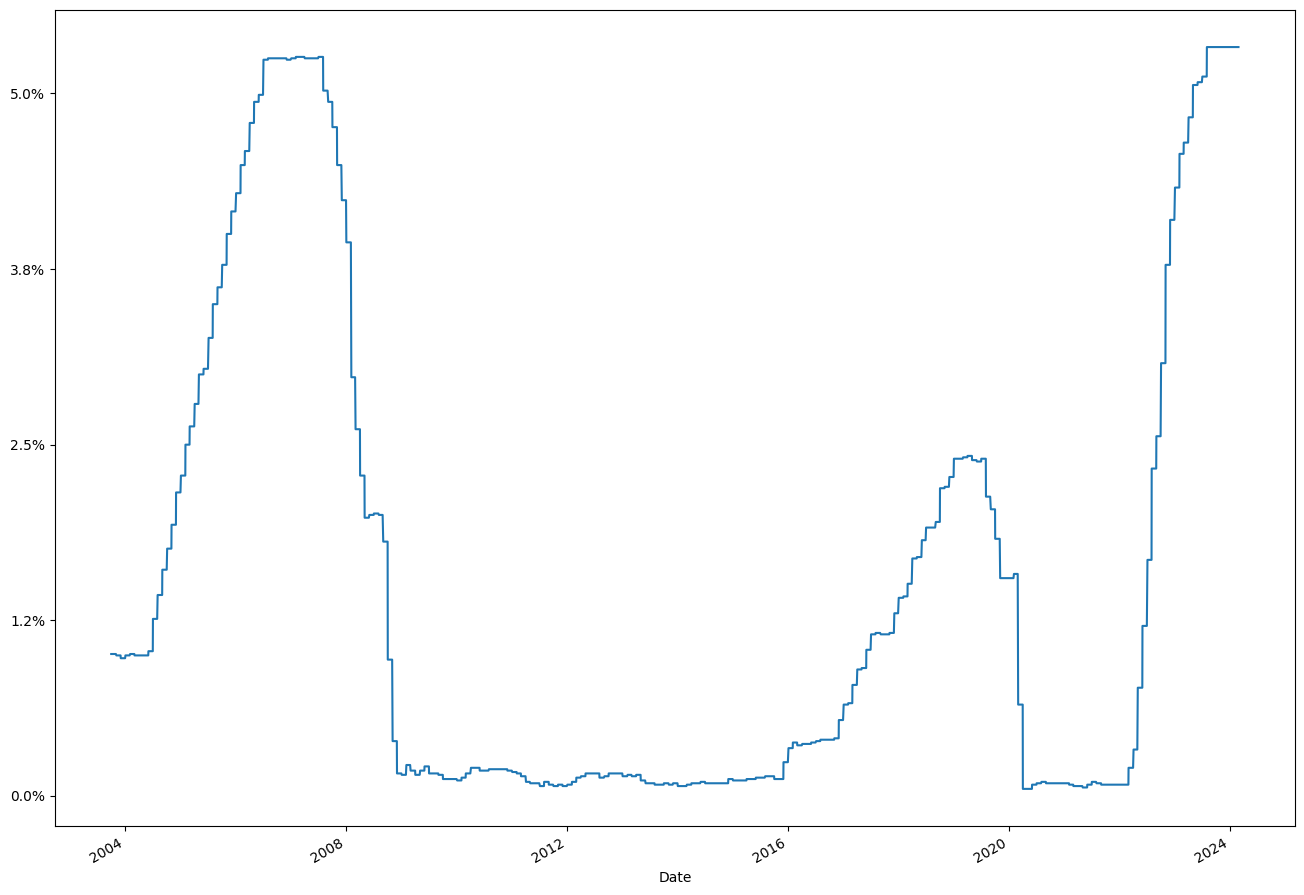

In [7]:
# https://fred.stlouisfed.org/series/FEDFUNDS
# !curl -o FEDFUNDS.csv -L URL

fed_rate = pd.read_csv("FEDFUNDS.csv").rename(columns=lambda xs: xs.lower())
fed_rate.date = pd.to_datetime(fed_rate.date)
fed_rate = fed_rate.set_index("date")

rfr = (
    fed_rate.iloc[fed_rate.index.searchsorted(rets.index) - 1]
    .set_index(rets.index).fedfunds
    .div(100).div(250).rename(None)
)
borrow = rfr + 0.01 / 250
ax = rfr.plot()
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1 / 250))

In [8]:
def cta_calibration(s):
    from sklearn.linear_model import LinearRegression

    calibration_df = rets[["cta", s]].rolling(90).mean().dropna()

    y, X = patsy.dmatrices(f'{s} ~ cta', data=calibration_df, return_type='dataframe')
    mod = sm.OLS(y, X)
    res = mod.fit()
    print(res.summary())
    
    print(res.params)
    print(res.params.Intercept * 250)
    
    return pd.Series(res.predict(patsy.dmatrix('~ cta', data=rets, return_type='dataframe')), index=rets.index)

In [9]:
# DBMF really does seem to track the CTA index with an additional 2% from not charging as much

dbmf_proxy = cta_calibration("dbmf")
rets["dbmf_proxy"] = rets["dbmf"].fillna(dbmf_proxy)

                            OLS Regression Results                            
Dep. Variable:                   dbmf   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     6233.
Date:                Sat, 09 Mar 2024   Prob (F-statistic):               0.00
Time:                        18:45:47   Log-Likelihood:                 7429.3
No. Observations:                1120   AIC:                        -1.485e+04
Df Residuals:                    1118   BIC:                        -1.484e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.852e-05   1.02e-05      1.808      0.0

In [10]:
base_list = ["spy", "agg", "dbmf_proxy"]

In [11]:
rets = rets.dropna(subset=base_list)

In [12]:
rets_spread = rets.sub(borrow, axis=0)

In [13]:
def plot_dd(rets):
    c_pl = rets.add(1).cumprod()

    ax = c_pl.plot(lw=1, color='black', logy=True)
    plt.fill_between(
        c_pl.index,
        c_pl,
        c_pl.cummax(),
        facecolor='red',
        alpha=0.5,
    )
    
    dds = (
        rets.add(1).cumprod()
        .transform(lambda xs: xs / xs.cummax() < 1)
        .rename("in_dd").to_frame()
        .assign(
            dd_no=lambda df: (df.in_dd & ~df.in_dd.shift(fill_value=False)).cumsum(),
            n_days=rets.index.to_series().diff().dt.days,
        )
        .groupby("dd_no").n_days.cumsum().div(365)
    )
    dds.plot(ax=ax, secondary_y=True, ylim=(None, dds.max() * 2))

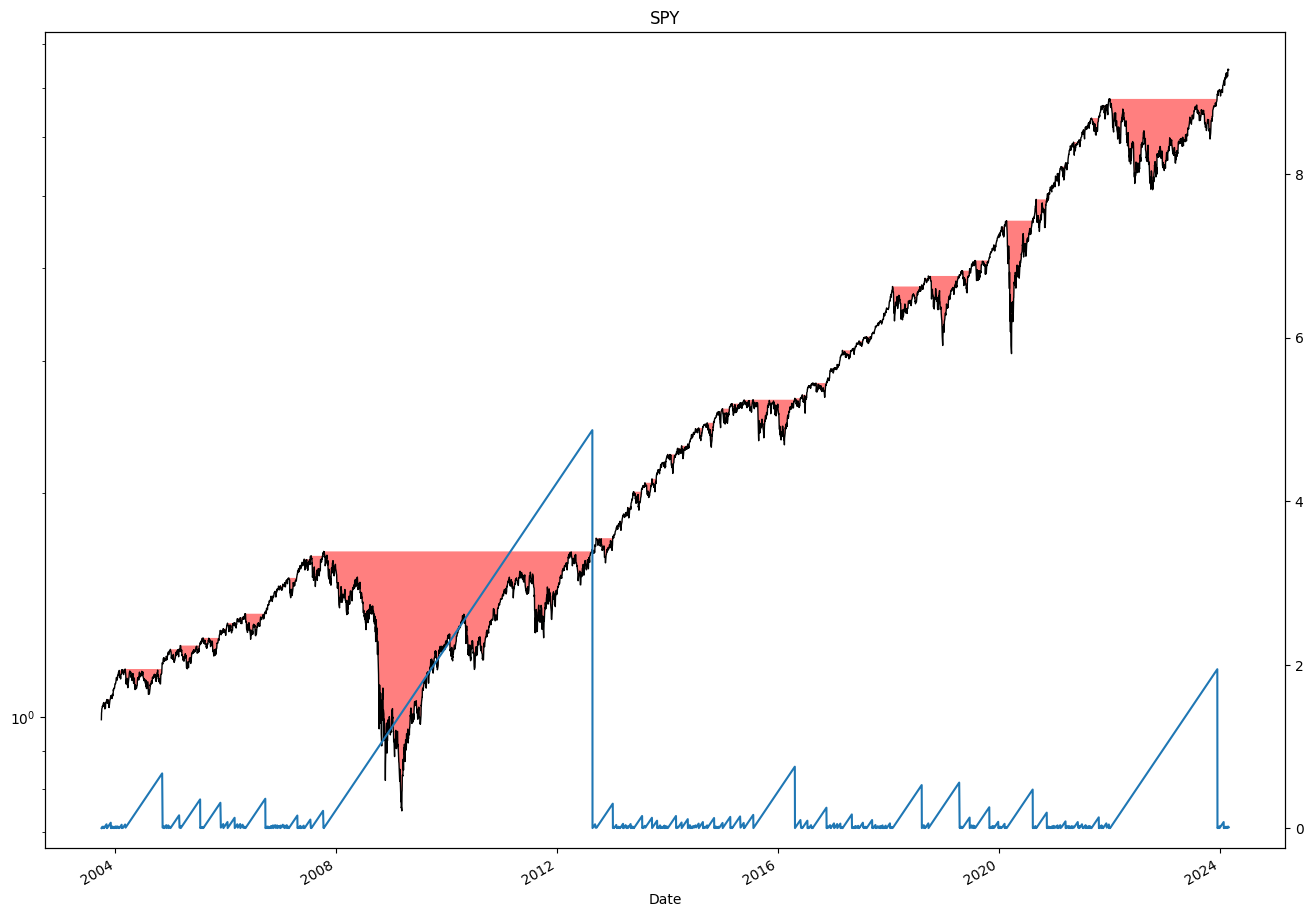

In [14]:
plot_dd(rets["spy"])
plt.title("SPY");

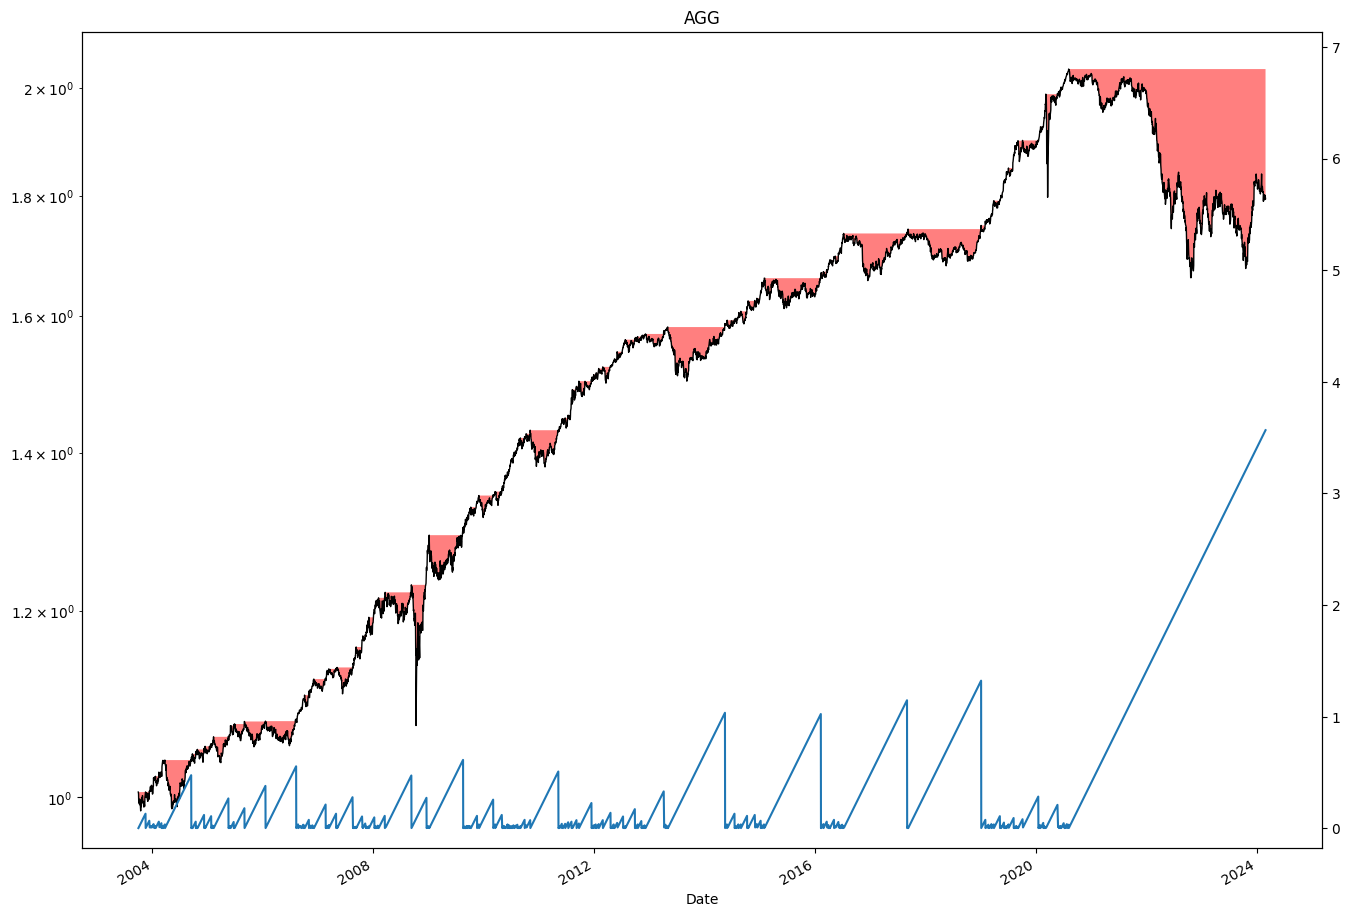

In [15]:
plot_dd(rets["agg"])
plt.title("AGG");

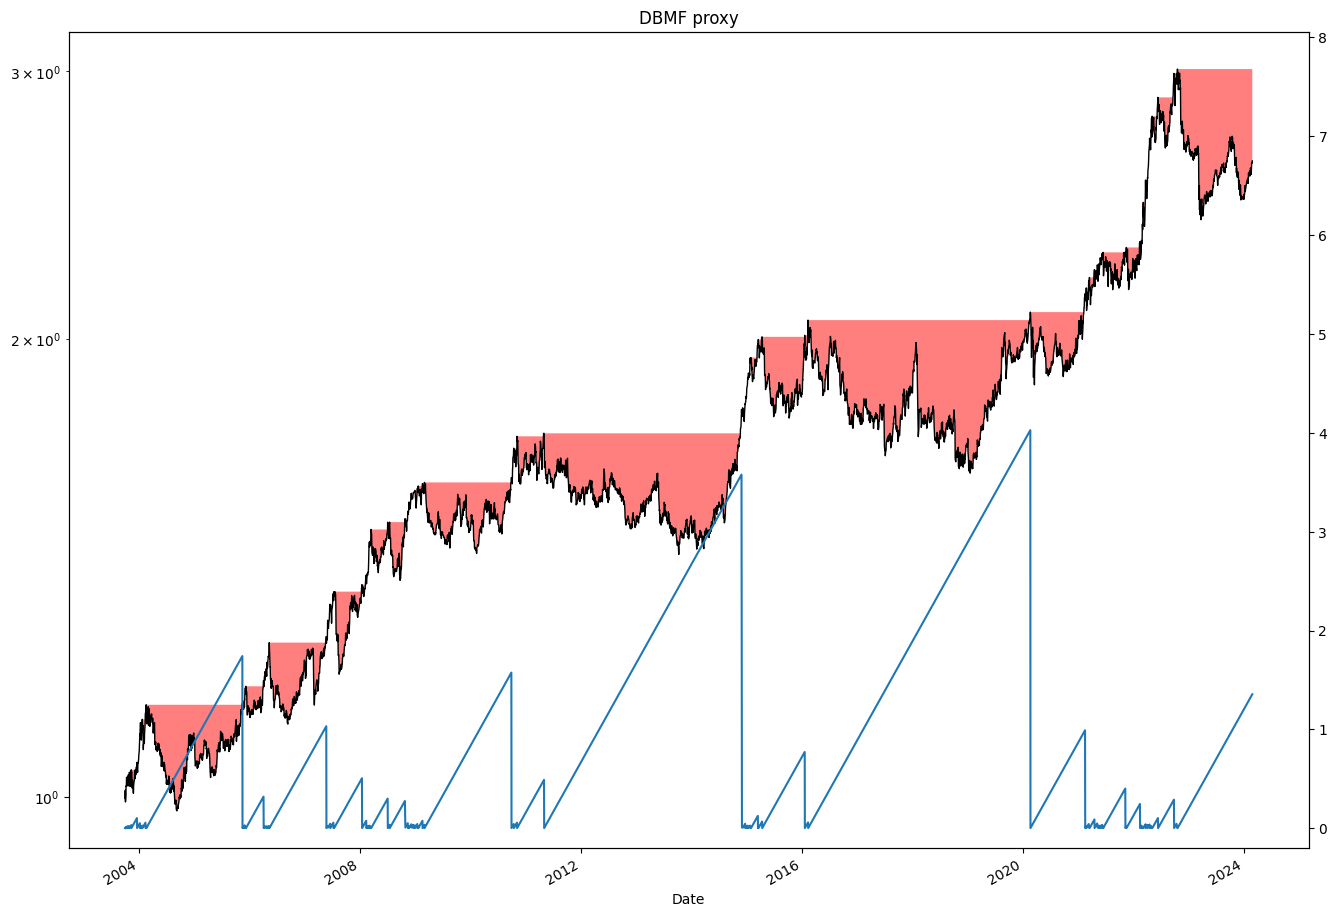

In [16]:
plot_dd(rets["dbmf_proxy"])
plt.title("DBMF proxy");

In [179]:
# def nlogret(xs):
#     return -(
#         rets_spread
#         .mul(pd.Series(dict(zip(base_list, xs))))
#         .sum(axis=1).add(borrow, axis=0).add(1).apply(np.log).mean()
#     )

# res = minimize(nlogret, [1] * 3, bounds=[(0., 3), (0., 3), (3., 3)])
# w = pd.Series(dict(zip(base_list, res.x))).div(3)
# w_name = "/".join([f"{x:02.0f}" for x in w.mul(100)])
# w = w.rename(w_name)
# w

In [180]:
# plot_dd(rets_spread.mul(w).sum(axis=1).add(borrow))

In [178]:
rets_spread[base_list].rolling(200).mean().corr()

,spy,agg,dbmf_proxy
spy,1.000000,0.200478,-0.175497
agg,0.200478,1.000000,-0.148373
dbmf_proxy,-0.175497,-0.148373,1.000000


In [54]:
strats = pd.concat([
#     rets_spread.mul(w).sum(axis=1).rename(w.name),
    rets_spread.eval("0.9 * spy + 0.6 * agg + 0.5 * dbmf_proxy").rename("90/60/50"),
    rets_spread.eval("0.9 * spy + 0.6 * agg + 0.3 * dbmf_proxy").rename("90/60/30"),
    rets_spread.eval("0.9 * spy + 0.6 * agg + 0.1 * dbmf_proxy").rename("90/60/10"),
    rets_spread.eval("0.9 * spy + 0.5 * dbmf_proxy").rename("90/0/50"),
    rets_spread.eval("0.9 * spy + 0.6 * agg").rename("90/60/0"),
    rets_spread["spy"].rename("100/0/0"),
    rets_spread["spy"].mul(1.2).rename("120/0/0"),
], axis=1).add(borrow, axis=0)

<AxesSubplot: title={'center': 'Max drawdowns'}, xlabel='Date'>

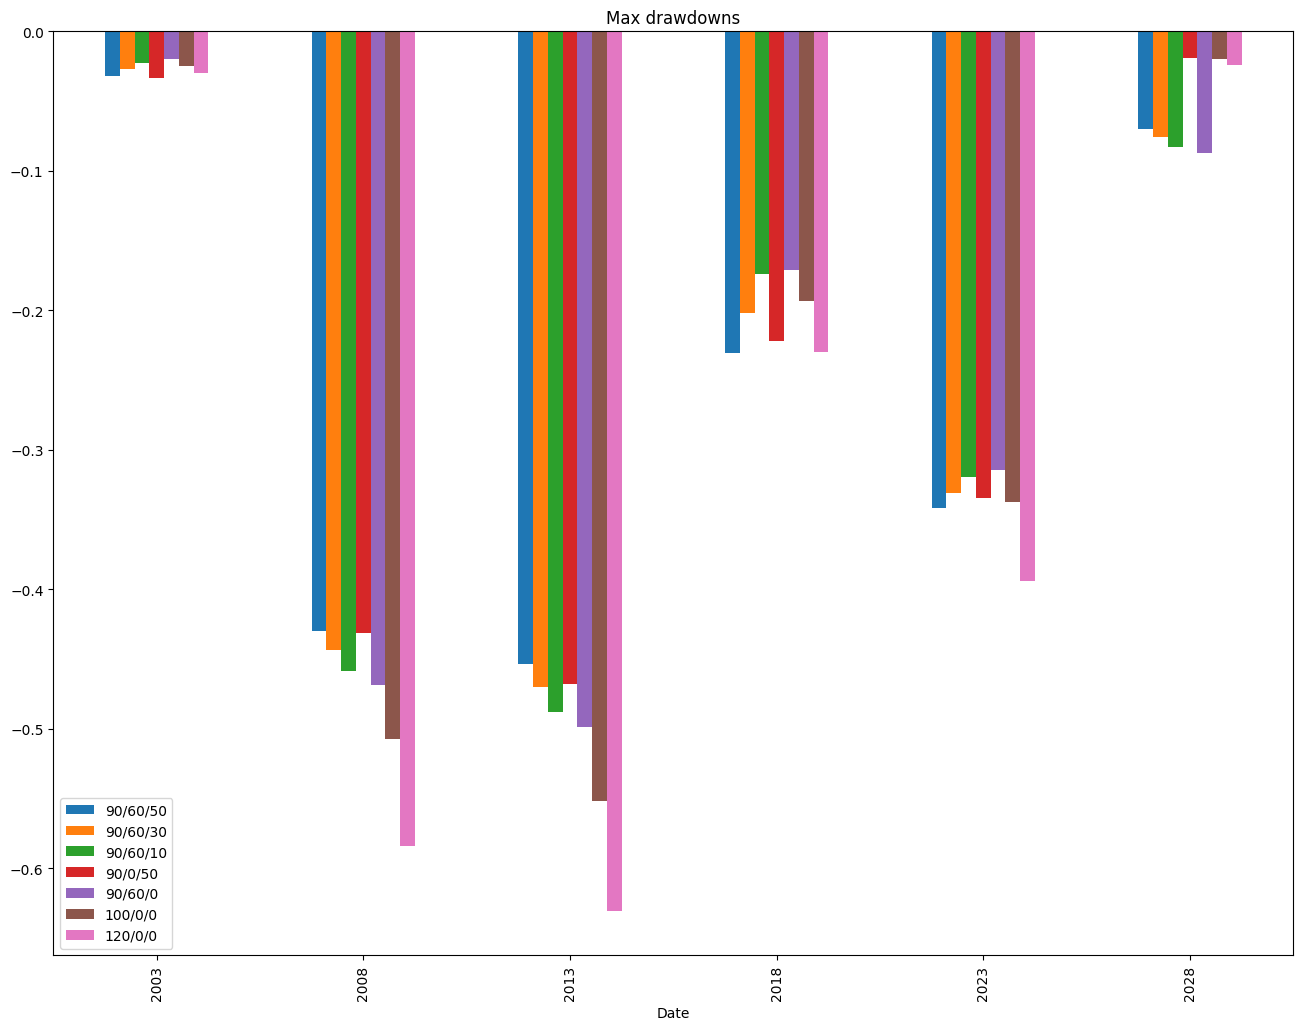

In [55]:
(
    strats.add(1).cumprod().transform(lambda xs: xs / xs.cummax() - 1)
    .groupby(pd.Grouper(freq="5Y")).min()
    .rename(index=lambda xs: xs.year)
    .plot.bar(title="Max drawdowns")
)

In [149]:
strats.std()

90/60/50    0.011491
90/60/30    0.011111
90/60/10    0.010888
90/0/50     0.011373
90/60/0     0.010839
100/0/0     0.011881
120/0/0     0.014258
dtype: float64

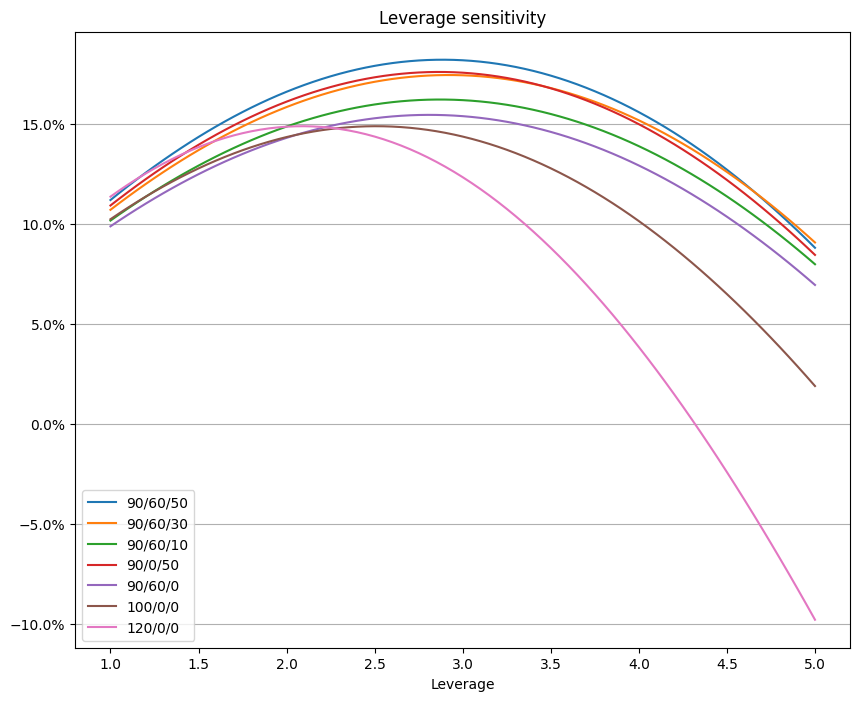

In [163]:
leverage_levels = np.linspace(1, 5, 81)

leveraged_returns = pd.DataFrame([
    strats.sub(borrow, axis=0).mul(l).add(borrow, axis=0)
    .add(1).apply(np.log).mean().mul(250).apply(np.exp).sub(1).rename(l)
    for l in leverage_levels
], index=pd.Index(leverage_levels, name="Leverage")).T

leveraged_drawdowns = pd.DataFrame([
    strats.sub(borrow, axis=0).mul(l).add(borrow, axis=0)
    .add(1).apply(np.log).cumsum()
    .transform(lambda xs: xs - xs.cummax()).min()
    .apply(np.exp).sub(1)
    for l in leverage_levels
], index=pd.Index(leverage_levels, name="Leverage")).T

results = (
    pd.concat([
        leveraged_returns, 
        leveraged_drawdowns,
    ], axis=1, keys=[
        "Ret", "DD",
    ])
)

display(
    results.T.unstack(level=0)
    .query("Leverage % 0.5 == 0")
    .style
    .format(precision=3)
    .background_gradient(
        axis=None, cmap="viridis", 
        subset=pd.IndexSlice[:, pd.IndexSlice[:, "Ret"]]
    )
    .background_gradient(
        axis=None, cmap="viridis", 
        subset=pd.IndexSlice[:, pd.IndexSlice[:, "DD"]]
    )
)

ax = leveraged_returns.T.plot(title="Leverage sensitivity", figsize=(10, 8))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.))
ax.grid(axis="y")

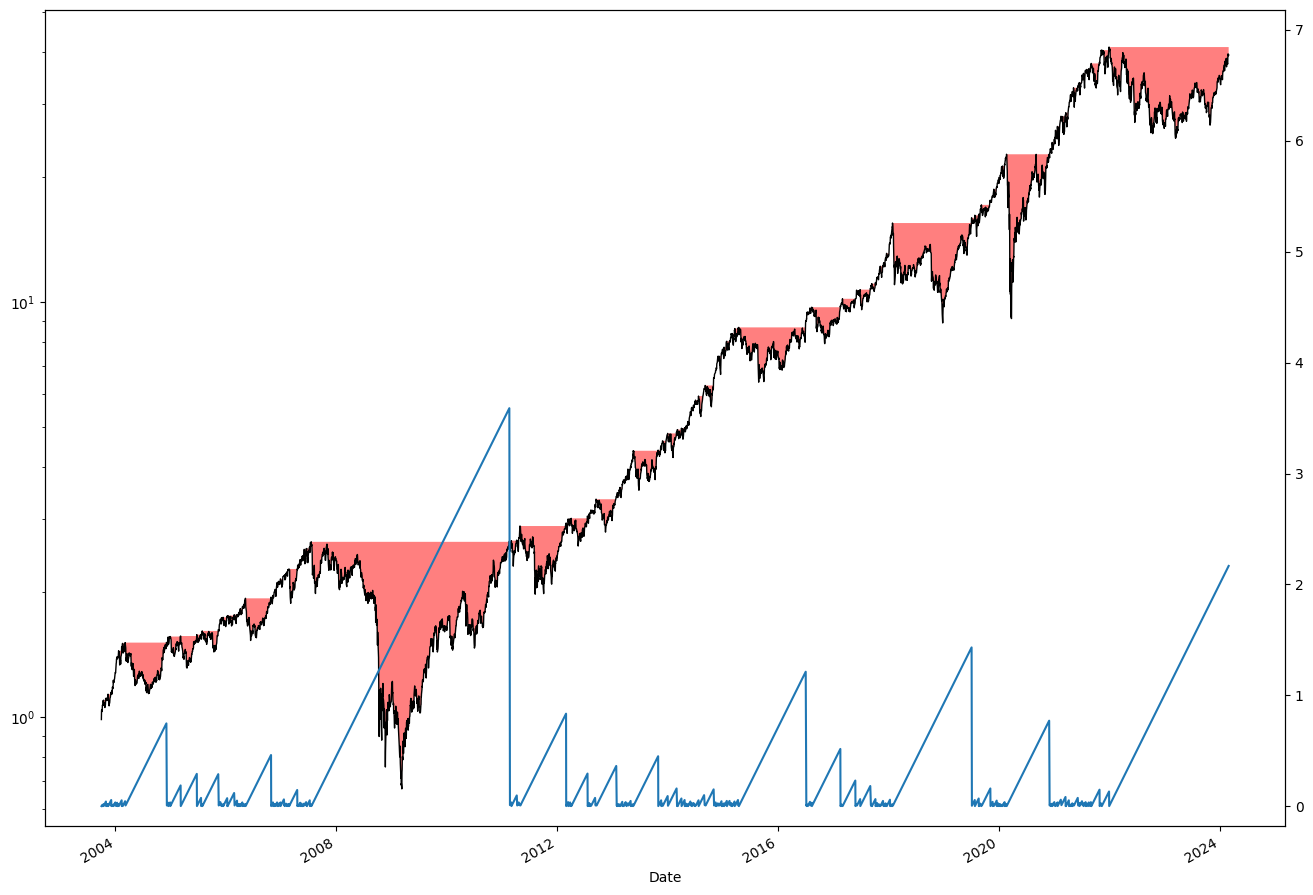

In [70]:
plot_dd(strats["90/60/50"].mul(2))

<AxesSubplot: xlabel='Date'>

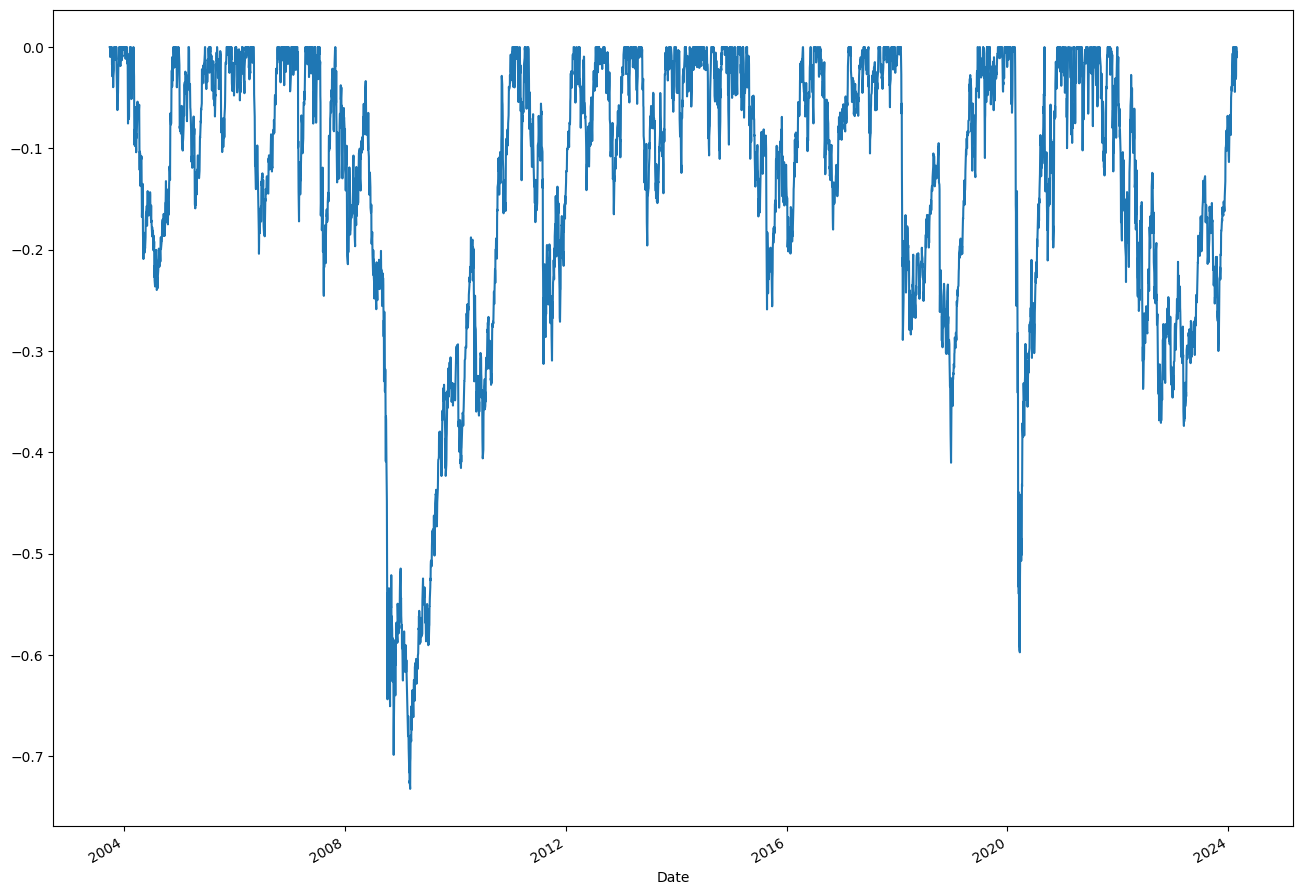

In [73]:
(
    strats["90/60/50"].add(borrow).mul(2).sub(borrow)
    .add(1).cumprod()
    .transform(lambda xs: xs / xs.cummax() - 1)
    .plot()
)